In [1]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Import the wordcloud library
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [4]:
import os
pwd = os.getcwd()

In [5]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [6]:
emails.count()

file       517401
message    517401
dtype: int64

In [7]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[1000:3000]
print(email_subset.shape)
print(email_subset.head())

(2000, 2)
                            file  \
1000  allen-p/all_documents/462.   
1001  allen-p/all_documents/463.   
1002  allen-p/all_documents/464.   
1003  allen-p/all_documents/465.   
1004  allen-p/all_documents/466.   

                                                message  
1000  Message-ID: <1081797.1075855696183.JavaMail.ev...  
1001  Message-ID: <28830232.1075855696211.JavaMail.e...  
1002  Message-ID: <23711632.1075855696233.JavaMail.e...  
1003  Message-ID: <28968716.1075855696255.JavaMail.e...  
1004  Message-ID: <2413536.1075855696276.JavaMail.ev...  


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [8]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [9]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0,
        'print': np.nan
    }

In [10]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))

In [13]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 07",0,0,0,0,NaN
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 04",0,0,0,0,NaN


In [14]:
email_df.count()

body     1888
to       1888
from_    1888
date     1888
TC       1888
SN       1888
KS       1888
OT       1888
print       0
dtype: int64

In [15]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][1]

'I also need to know the base salaries of Jay Reitmeyer and Monique Sanchez.They are doing the same job as Matt.'

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [16]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [17]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [18]:
email_df['text_processed'][1]

'i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

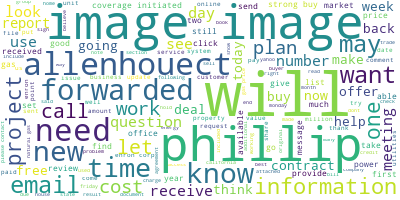

In [19]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [20]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
email_df.to_pickle('email.pickle')


In [23]:
# def manually_label(email_file):
    
# df = pd.read_pickle('email.pickle')
# for index, row in df.iterrows():
#         print('Is this sentence? Type 1 if team communication,',
#               '\nType 2: social networking,','\nType 3:  knowledge sharing and ',
#               '\nType 4: others . \n')
#         print(row.text_processed)
#         label = input()
#         print(label)
#         if '1' in label:
#             df.loc[index, 'TC'] = 1
#         if '2' in label:
#             df.loc[index, 'SN'] = 1
#         if '3' in label:
#             df.loc[index, 'KS'] = 1
#         if '4' in label:
#             df.loc[index, 'OT'] = 1
#         if label == '':
#             df.loc[index, 'OT'] = 1
#         clear_output()
        
#         df.to_pickle('email.pickle')
        
# print('No more labels to classify!')
    

In [24]:
# df.to_csv(os.path.basename(pwd +'/final_result1.csv'))

In [25]:
df = pd.read_csv(os.path.basename(pwd +'/final_train.csv'))

In [26]:
df.head(3)

,body,to,from,date,TC,SN,KS,OT,text_processed
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14-May-2001,1,0,0,0,here is our forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4-May-2001,0,1,0,0,traveling to have a business meeting takes the...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18-Oct-2000,1,0,0,0,test successful way to go


In [27]:
categories = ['TC','SN','KS','OT']

In [28]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))

In [29]:
df_stats = pd.DataFrame(counts, columns=['category','number_of_comments'])
df_stats

,category,number_of_comments
0,TC,643
1,SN,240
2,KS,143
3,OT,77


Text(0.5, 0, 'category')

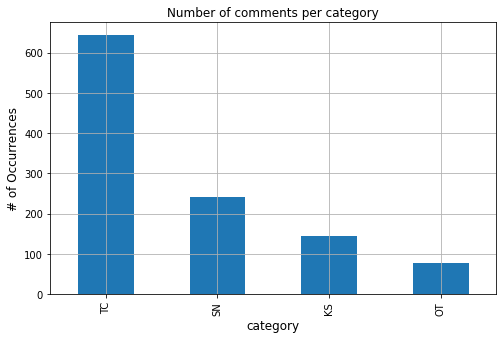

In [30]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

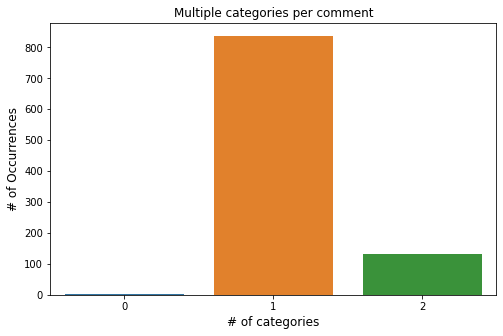

In [31]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [32]:
df.dtypes

body              object
to                object
from              object
date              object
TC                 int64
SN                 int64
KS                 int64
OT                 int64
text_processed    object
dtype: object

In [33]:
from sklearn.model_selection import train_test_split
categories = ['TC', 'SN', 'KS', 'OT']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.text_processed
X_test = test.text_processed
print(X_train.shape)
print(X_test.shape)

(650,)
(321,)


In [34]:
X_train.head()

922    forwarded by phillip k allenhouect on 04102001...
90     open the utility spreadsheet and try to comple...
911    jeffi am in the office today any isssues to de...
181    forwarded by phillip k allenhouect on 04282000...
274    forwarded by phillip k allenhouect on 05072001...
Name: text_processed, dtype: object

In [35]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Pad Sequence: Normally model expects that each text sequence  will be of the same length 

In [36]:
# maxlen = 750 # max number of words in a question to use
# train = pad_sequences(xtrain, maxlen=maxlen)
# test = pad_sequences(xtest, maxlen=maxlen)

In [37]:
df_result = pd.DataFrame(columns=('Type',  'Model', 'Accuray','Precision',
                                   'Recall','Fmeasure'))

### Naive Bayes

In [38]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [39]:
result=[]
count = 0
# df_result.set_index('Type')
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'NB',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

    

... Processing TC
... Processing SN
... Processing KS
... Processing OT


C:\Users\shrad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Linear SVC

In [40]:
from sklearn.svm import LinearSVC
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


In [41]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'SVC',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [43]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'LR',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Artificial Neural Network

In [44]:
X_train.head()

922    forwarded by phillip k allenhouect on 04102001...
90     open the utility spreadsheet and try to comple...
911    jeffi am in the office today any isssues to de...
181    forwarded by phillip k allenhouect on 04282000...
274    forwarded by phillip k allenhouect on 05072001...
Name: text_processed, dtype: object

In [46]:
x_train = X_train.map(lambda com : clean_text(com))
x_train = X_train.map(lambda x: x.lower())


x_test = X_test.map(lambda com : clean_text(com))
x_test = X_test.map(lambda x: x.lower())

In [48]:

vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_seq = tokenizer.texts_to_sequences(x_train)


tokenizer.fit_on_texts(x_test)
word_index = tokenizer.word_index
x_seq_test = tokenizer.texts_to_sequences(x_test)

In [49]:
max([len(e) for e in x_seq])

1458

In [50]:
padding_type = 'post'
max_len = 1500
x_train = pad_sequences(x_seq, padding=padding_type, maxlen=max_len)

x_test = pad_sequences(x_seq_test, padding=padding_type, maxlen=max_len)

In [51]:
import tensorflow as tf
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, 32, input_length=x_train.shape[1]),
                            tf.keras.layers.GlobalAveragePooling1D(),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 32)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 641,089
Trainable params: 641,089
Non-trainable params: 0
__________________________________________________

In [53]:
from sklearn import metrics
for category in categories:
    print('... Processing {}'.format(category))
    model.fit(x_train,  train[category], epochs=50)

    # compute the testing accuracy
    prediction = model.predict(x_test)
    score = model.evaluate(x_test,test[category], verbose=0)
    result = {'Type' :category,
              'Model' : 'ANN',
              
             ('Accuray' ):   score[1],
             ('Precision' ) :precision_score(test[category], prediction.round()),
             ('Recall') :recall_score(test[category], prediction.round()),
             ('Fmeasure') :metrics.f1_score(test[category], prediction.round(), average= "weighted") }
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
Epoch 1/50


C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


21/21 [==============================] - 1s 26ms/step - loss: 0.6792 - accuracy: 0.6723
Epoch 2/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6609 - accuracy: 0.6692
Epoch 3/50
21/21 [==============================] - 1s 25ms/step - loss: 0.6455 - accuracy: 0.6692
Epoch 4/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6378 - accuracy: 0.6692
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6390 - accuracy: 0.6692
Epoch 6/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6353 - accuracy: 0.6692
Epoch 7/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6376 - accuracy: 0.6692
Epoch 8/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6368 - accuracy: 0.6692
Epoch 9/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6339 - accuracy: 0.6692
Epoch 10/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6305 - accuracy: 0.6692
Epoch 11/50
21/21 [=

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


... Processing SN
Epoch 1/50
 3/21 [===>..........................] - ETA: 0s - loss: 1.5439 - accuracy: 0.2500

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


21/21 [==============================] - 1s 27ms/step - loss: 1.3832 - accuracy: 0.5046
Epoch 2/50
21/21 [==============================] - 1s 27ms/step - loss: 0.9020 - accuracy: 0.6938
Epoch 3/50
21/21 [==============================] - 1s 27ms/step - loss: 0.7486 - accuracy: 0.7031
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6955 - accuracy: 0.7031
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.6422 - accuracy: 0.7215
Epoch 6/50
21/21 [==============================] - 1s 28ms/step - loss: 0.6119 - accuracy: 0.7277
Epoch 7/50
21/21 [==============================] - 1s 28ms/step - loss: 0.6057 - accuracy: 0.7308
Epoch 8/50
21/21 [==============================] - 1s 26ms/step - loss: 0.5723 - accuracy: 0.7431
Epoch 9/50
21/21 [==============================] - 1s 27ms/step - loss: 0.5509 - accuracy: 0.7446
Epoch 10/50
21/21 [==============================] - 1s 27ms/step - loss: 0.5438 - accuracy: 0.7523
Epoch 11/50
21/21 [=

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


... Processing KS
Epoch 1/50
 1/21 [>.............................] - ETA: 0s - loss: 1.6130 - accuracy: 0.6562

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


21/21 [==============================] - 1s 30ms/step - loss: 1.1705 - accuracy: 0.8092
Epoch 2/50
21/21 [==============================] - 1s 27ms/step - loss: 0.8424 - accuracy: 0.8477
Epoch 3/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6449 - accuracy: 0.8492
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.5220 - accuracy: 0.8477
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.4639 - accuracy: 0.8523
Epoch 6/50
21/21 [==============================] - 1s 27ms/step - loss: 0.4081 - accuracy: 0.8585 0s - loss: 0.3698 - 
Epoch 7/50
21/21 [==============================] - 1s 27ms/step - loss: 0.3652 - accuracy: 0.8708 0s - loss: 0.3762 - accu
Epoch 8/50
21/21 [==============================] - 1s 25ms/step - loss: 0.3496 - accuracy: 0.8738
Epoch 9/50
21/21 [==============================] - 1s 26ms/step - loss: 0.3194 - accuracy: 0.8800
Epoch 10/50
21/21 [==============================] - ETA: 0s - loss: 0.303

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


... Processing OT
Epoch 1/50
 5/21 [======>.......................] - ETA: 0s - loss: 0.9619 - accuracy: 0.8062

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


21/21 [==============================] - 1s 25ms/step - loss: 0.7217 - accuracy: 0.8431
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 0.4384 - accuracy: 0.8800
Epoch 3/50
21/21 [==============================] - 1s 26ms/step - loss: 0.3272 - accuracy: 0.8938
Epoch 4/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2899 - accuracy: 0.9185
Epoch 5/50
21/21 [==============================] - 1s 27ms/step - loss: 0.2724 - accuracy: 0.9169
Epoch 6/50
21/21 [==============================] - 1s 25ms/step - loss: 0.2698 - accuracy: 0.9246
Epoch 7/50
21/21 [==============================] - 1s 27ms/step - loss: 0.2746 - accuracy: 0.9246
Epoch 8/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2684 - accuracy: 0.9246
Epoch 9/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2705 - accuracy: 0.9246
Epoch 10/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2620 - accuracy: 0.9246
Epoch 11/50
21/21 [=

C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\shrad\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\shrad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
from sklearn.linear_model import LogisticRegression
RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier())),
            ])

In [56]:
for category in categories:
    print('... Processing {}'.format(category))

    RF_pipeline.fit(X_train, train[category])

    prediction = RF_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'RF',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Deep Learning :Pytorch Model - TextCNN

In [57]:
import torch.nn as nn
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.optim.optimizer import Optimizer

embed_size = 300 # how big is each word vector

In [58]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
#         n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
#         self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

### SVM

In [60]:
from sklearn.svm import SVC
SVM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', SVC()),
            ])

In [61]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVM_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVM_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'SVM',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


In [102]:
df_result.head()

,Type,Model,Accuray,Precision,Recall,Fmeasure
0,TC,NB,0.700935,0.689189,0.980769,0.809524
1,SN,NB,0.753894,1.000000,0.012500,0.024691
2,KS,NB,0.869159,0.833333,0.108696,0.192308
3,OT,NB,0.912773,0.000000,0.000000,0.000000
4,TC,SVC,0.725857,0.729008,0.918269,0.812766


In [114]:
result = pd.pivot_table(df_result, index=['Model', 'Type'], values=['Accuray','Precision','Recall','Fmeasure'])
result

Accuray  Fmeasure  Precision    Recall
Model Type                                         
ANN   KS    0.912773  0.906027   0.781250  0.543478
      OT    0.912773  0.871148   0.000000  0.000000
      SN    0.735202  0.664516   0.352941  0.075000
      TC    0.750779  0.749720   0.801887  0.817308
LR    KS    0.872274  0.196078   1.000000  0.108696
      OT    0.919003  0.187500   0.750000  0.107143
      SN    0.760125  0.072289   1.000000  0.037500
      TC    0.707165  0.815686   0.688742  1.000000
NB    KS    0.869159  0.192308   0.833333  0.108696
      OT    0.912773  0.000000   0.000000  0.000000
      SN    0.753894  0.024691   1.000000  0.012500
      TC    0.700935  0.809524   0.689189  0.980769
RF    KS    0.875389  0.444444   0.615385  0.347826
      OT    0.919003  0.409091   0.562500  0.321429
      SN    0.781931  0.588235   0.555556  0.625000
      TC    0.738318  0.802817   0.784404  0.822115
SVC   KS    0.872274  0.453333   0.586207  0.369565
      OT    0.925234  0.368421   0.700000  0.250000
      SN    0.775701  0.419355   0.590909  0.325000
      TC    0.725857  0.812766   0.729008  0.918269
SVM   KS    0.884735  0.447761   0.714286  0.326087
      OT    0.922118  0.285714   0.714286  0.178571
      SN    0.785047  0.378378   0.677419  0.262500
      TC    0.719626  0.814050   0.713768  0.947115

In [65]:
df["Month"] = list(map(lambda x: datetime.strptime(x,'%d-%b-%Y').strftime('%B'), df['date']))
df["Year"] = list(map(lambda x: datetime.strptime(x,'%d-%b-%Y').strftime('%Y'), df['date']))
df.head()

,body,to,from,date,TC,SN,KS,OT,text_processed,Month,Year
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14-May-2001,1,0,0,0,here is our forecast,May,2001
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4-May-2001,0,1,0,0,traveling to have a business meeting takes the...,May,2001
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18-Oct-2000,1,0,0,0,test successful way to go,October,2000
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,23-Oct-2000,1,0,0,0,randycan you send me a schedule of the salary ...,October,2000
4,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,31-Aug-2000,0,1,0,0,greghow about either next tuesday or thursdayp...,August,2000


In [66]:
df.drop(['body', 'to', 'date'], axis=1, inplace=True)

<AxesSubplot:xlabel='Year,Month'>

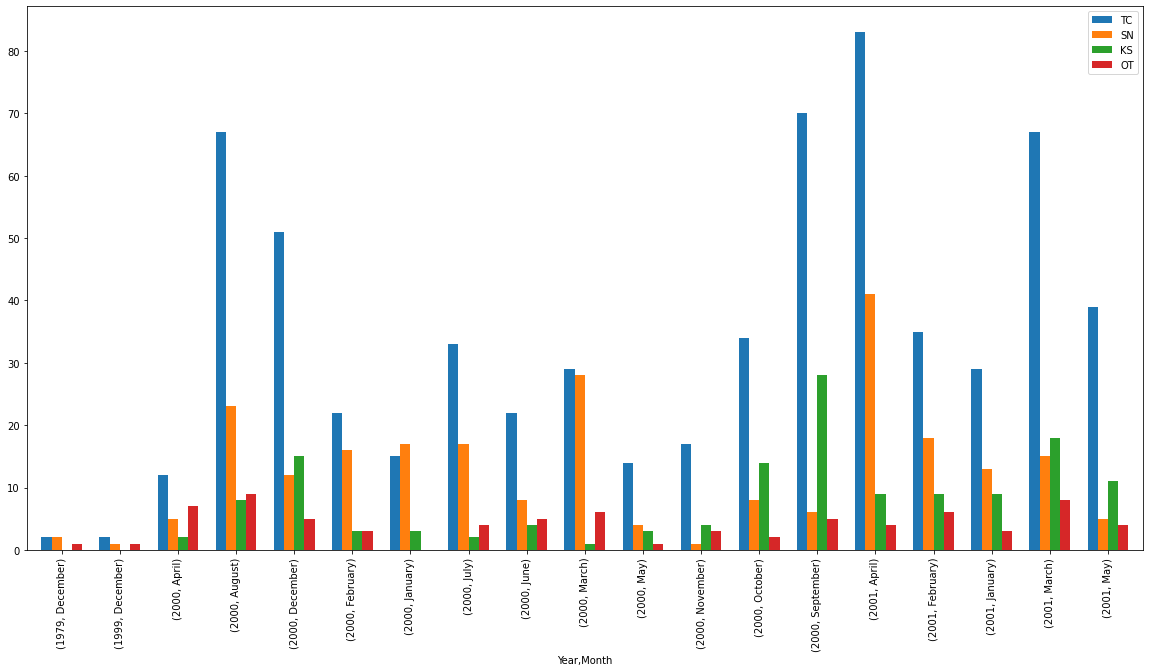

In [67]:
df.groupby(['Year','Month']).sum().plot(kind="bar",figsize=(20,10), width = 0.7)


In [68]:
df['from'] = df['from'].str.split('@').str[0]
df['from'] = df['from'].str.replace('\d+', '')


<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-68-9109712eda1f>:2: DeprecationWarning: invalid escape sequence \d
  df['from'] = df['from'].str.replace('\d+', '')


In [69]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['from'] = df['from'].str.replace(char, ' ')

In [70]:
df['from'].value_counts()

phillip allen               884
Phillip K Allen               5
critical notice               5
ina rangel                    4
Phillip K Allen  mailto       4
Leslie Lawner                 4
Allen  Phillip                3
Frank Hayden ENRON            3
Sarah Novosel                 3
James D Steffes               2
pallen                        2
ei editor                     2
announce                      2
Steven J Kean                 2
sarah novosel                 2
webmaster                     2
Andy Chen on                  2
Kristin Walsh ENRON           2
jsmith                        2
aod                           2
Mark Whitt                    2
rob tom                       1
rebecca cantrell              1
tiffany miller                1
jfreeman                      1
 Kristin Walsh ENRON          1
yahoo delivers                1
kim ward                      1
lisa jacobson                 1
billc                         1
yild                          1
bobregon

### Calculate Negative and Positive Sentiment

In [71]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:

#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in df['text_processed']]
#add the sentiment metrics to the dataframe
df['tb_Pol'] = [b.sentiment.polarity for b in desc_blob]
df['tb_Subj'] = [b.sentiment.subjectivity for b in desc_blob]
#show dataframe
df.head(3)



,from,TC,SN,KS,OT,text_processed,Month,Year,tb_Pol,tb_Subj
0,phillip allen,1,0,0,0,here is our forecast,May,2001,0.00,0.000000
1,phillip allen,0,1,0,0,traveling to have a business meeting takes the...,May,2001,0.20,0.563333
2,phillip allen,1,0,0,0,test successful way to go,October,2000,0.75,0.950000


In [73]:
#load VADER
analyzer = SentimentIntensityAnalyzer()
#Add VADER metrics to dataframe
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['text_processed']]
df['negative'] = [analyzer.polarity_scores(v)['neg'] for v in df['text_processed']]
df['neutral']  = [analyzer.polarity_scores(v)['neu'] for v in df['text_processed']]
df['positive'] = [analyzer.polarity_scores(v)['pos'] for v in df['text_processed']]
df.head(3)

,from,TC,SN,KS,OT,text_processed,Month,Year,tb_Pol,tb_Subj,compound,negative,neutral,positive
0,phillip allen,1,0,0,0,here is our forecast,May,2001,0.00,0.000000,0.0000,0.0,1.000,0.000
1,phillip allen,0,1,0,0,traveling to have a business meeting takes the...,May,2001,0.20,0.563333,0.9313,0.0,0.892,0.108
2,phillip allen,1,0,0,0,test successful way to go,October,2000,0.75,0.950000,0.5859,0.0,0.513,0.487


In [74]:
df.drop([ 'text_processed','tb_Pol', 'tb_Subj','compound'], axis=1, inplace=True)

In [75]:
df_sum   = pd.pivot_table(df, index=['from','Year','Month'],values=['TC','SN','KS','OT','negative', 'neutral','positive'],aggfunc=np.sum).reset_index()
df_count = df.groupby(['from','Year','Month'])["from"].count().reset_index(name="count")

In [76]:
# df_text = df.groupby(['from','Year','Month'])['text_processed'].apply(lambda x: ','.join(x)).reset_index()

In [77]:
df_final = pd.concat([df_sum,df_count['count']],axis=1)

In [78]:
df_final = df_final.reindex(columns = ['from', 'Month', 'Year','count',
                  'SN', 'KS', 'TC', 'OT','negative','neutral','positive'] )
df_final.head()

,from,Month,Year,count,SN,KS,TC,OT,negative,neutral,positive
0,,December,2000,1,0,1,1,0,0.009,0.851,0.141
1,Kristin Walsh ENRON,May,2001,1,0,1,1,0,0.044,0.920,0.035
2,Wesko George gwesko,January,2000,1,0,0,1,0,0.000,0.760,0.240
3,Allen Phillip,April,2001,3,1,0,2,0,0.000,2.630,0.370
4,Andy Chen on,July,2000,2,0,0,2,0,0.000,2.000,0.000


In [79]:
df_final.to_csv(os.path.basename(pwd +'/Panel_data.csv'))

In [80]:
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,lucyhere is the rentrollmy only questions are ...
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,i also need to know the base salaries of jay r...
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,thanks for the information it would be helpful...
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...


In [81]:
df.to_csv(os.path.basename(pwd +'/final_test.csv'))

In [82]:
print(email_df.iloc[1]['text_processed'])

i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt


In [83]:
data = email_df.text_processed.values.tolist()

In [84]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [85]:
data_words = list(sent_to_words(data))

In [86]:
print(data_words[1])

['also', 'need', 'to', 'know', 'the', 'base', 'salaries', 'of', 'jay', 'reitmeyer', 'and', 'monique', 'sanchezthey', 'are', 'doing', 'the', 'same', 'job', 'as', 'matt']


In [87]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [88]:
# data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = lemmatization(data_words_nostops)

In [89]:
print(data_lemmatized[1])

['also', 'need', 'know', 'base', 'salary', 'jay', 'reitmeyer', 'monique', 'sanchezthey', 'job', 'matt']


### Bag of Words on the Data set

In [90]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [91]:
print('Number of unique words in initital documents:', len(dictionary))

Number of unique words in initital documents: 16344


In [92]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words after removing rare and common words: 1344


In [93]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ad
1 discount
2 five
3 going
4 letter
5 like
6 look
7 lucyhere
8 missed
9 need
10 next


### Gensim doc2bow

In [94]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[489]

[(56, 1),
 (105, 3),
 (118, 1),
 (186, 1),
 (200, 1),
 (290, 1),
 (415, 2),
 (440, 1),
 (521, 1),
 (589, 1),
 (682, 1),
 (729, 1),
 (871, 1),
 (925, 1),
 (1028, 1),
 (1039, 1),
 (1299, 1)]

In [95]:
bow_doc_489 = bow_corpus[489]
for i in range(len(bow_doc_489)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_489[i][0], 
                                               dictionary[bow_doc_489[i][0]], 
bow_doc_489[i][1]))

Word 56 ("please") appears 1 time.
Word 105 ("email") appears 3 time.
Word 118 ("austin") appears 1 time.
Word 186 ("service") appears 1 time.
Word 200 ("tx") appears 1 time.
Word 290 ("receive") appears 1 time.
Word 415 ("message") appears 2 time.
Word 440 ("common") appears 1 time.
Word 521 ("line") appears 1 time.
Word 589 ("road") appears 1 time.
Word 682 ("thank") appears 1 time.
Word 729 ("wish") appears 1 time.
Word 871 ("joe") appears 1 time.
Word 925 ("address") appears 1 time.
Word 1028 ("south") appears 1 time.
Word 1039 ("longer") appears 1 time.
Word 1299 ("replyto") appears 1 time.


### TF-IDF

In [96]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    if doc != []:
        pprint(doc)
        break

[(0, 0.3013197954885115),
 (1, 0.28339212170251354),
 (2, 0.2720302687844622),
 (3, 0.1643938997545552),
 (4, 0.24851817489694025),
 (5, 0.11360270062920255),
 (6, 0.14179855165841324),
 (7, 0.2541025949984642),
 (8, 0.2746824843961455),
 (9, 0.10156347516456478),
 (10, 0.18435470138731772),
 (11, 0.13396089765249478),
 (12, 0.23285684762153333),
 (13, 0.27745261425439766),
 (14, 0.19938335662233636),
 (15, 0.20356732091748403),
 (16, 0.16168400930236546),
 (17, 0.12853855218255927),
 (18, 0.1427697556383092),
 (19, 0.2670421944846301),
 (20, 0.28995794257046015)]


### LDA using Bag of Words

In [97]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10, 
                                       id2word=dictionary,
                                       passes=2, workers=2)

In [98]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.080*"buy" + 0.028*"downgraded" + 0.024*"strong" + 0.020*"initiated" + 0.017*"coverage" + 0.013*"please" + 0.013*"u" + 0.011*"hold" + 0.010*"nt" + 0.010*"market"
Topic: 1 
Words: 0.070*"image" + 0.010*"cost" + 0.008*"cash" + 0.007*"click" + 0.006*"know" + 0.006*"revenue" + 0.006*"let" + 0.006*"need" + 0.006*"phillip" + 0.005*"energy"
Topic: 2 
Words: 0.049*"email" + 0.012*"please" + 0.011*"information" + 0.011*"phillip" + 0.009*"message" + 0.008*"robert" + 0.006*"forwarded" + 0.006*"address" + 0.006*"call" + 0.006*"mike"
Topic: 3 
Words: 0.013*"power" + 0.010*"phillip" + 0.009*"plant" + 0.008*"customer" + 0.008*"information" + 0.007*"free" + 0.007*"time" + 0.007*"year" + 0.006*"price" + 0.006*"get"
Topic: 4 
Words: 0.012*"cost" + 0.011*"phillip" + 0.010*"please" + 0.010*"would" + 0.009*"get" + 0.007*"need" + 0.007*"forwarded" + 0.007*"rent" + 0.007*"look" + 0.007*"allenhouect"
Topic: 5 
Words: 0.014*"would" + 0.012*"need" + 0.012*"new" + 0.010*"work" + 0.009*"get" + 0

### Running LDA using TF-IDF

In [99]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                             id2word=dictionary,
                                             passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.016*"tim" + 0.010*"phillip" + 0.009*"allenhouect" + 0.009*"forwarded" + 0.005*"email" + 0.005*"attachment" + 0.005*"report" + 0.005*"please" + 0.004*"let" + 0.004*"would"
Topic: 1 Word: 0.006*"meeting" + 0.006*"tx" + 0.006*"get" + 0.005*"work" + 0.005*"info" + 0.005*"gas" + 0.005*"plan" + 0.005*"call" + 0.005*"email" + 0.004*"please"
Topic: 2 Word: 0.007*"cost" + 0.006*"phillip" + 0.006*"forwarded" + 0.005*"allenhouect" + 0.005*"loan" + 0.005*"would" + 0.005*"spreadsheet" + 0.005*"file" + 0.004*"format" + 0.004*"please"
Topic: 3 Word: 0.008*"gas" + 0.007*"file" + 0.006*"go" + 0.006*"load" + 0.006*"lgayenroncom" + 0.005*"forecast" + 0.005*"click" + 0.005*"notice" + 0.005*"pipeline" + 0.005*"following"
Topic: 4 Word: 0.017*"allenhouect" + 0.017*"forwarded" + 0.016*"phillip" + 0.006*"jeff" + 0.006*"west" + 0.006*"zdnet" + 0.006*"michael" + 0.005*"thanks" + 0.005*"email" + 0.005*"get"
Topic: 5 Word: 0.006*"fax" + 0.006*"email" + 0.005*"look" + 0.005*"image" + 0.005*"week" 

In [100]:
for index, score in sorted(lda_model[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9571323394775391	 
Topic: 0.049*"email" + 0.012*"please" + 0.011*"information" + 0.011*"phillip" + 0.009*"message" + 0.008*"robert" + 0.006*"forwarded" + 0.006*"address" + 0.006*"call" + 0.006*"mike"


In [101]:
for index, score in sorted(lda_model_tfidf[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8003085851669312	 
Topic: 0.010*"message" + 0.008*"original" + 0.008*"youphillip" + 0.007*"id" + 0.007*"please" + 0.007*"deal" + 0.006*"allen" + 0.006*"would" + 0.006*"west" + 0.004*"need"

Score: 0.16157828271389008	 
Topic: 0.017*"image" + 0.007*"please" + 0.007*"phillip" + 0.007*"email" + 0.007*"forwarded" + 0.006*"buy" + 0.006*"allenhouect" + 0.005*"gas" + 0.005*"call" + 0.005*"enron"
